Define the methods for data formatting and validating train, dev, test splits.

In [8]:
# Define a method for creating a train, dev, test split
def train_dev_test_split(data, p_train, p_dev):
    total_number = len(data)
    # convert percentage to decimal
    p_train = p_train/100
    # convert percentage to decimal, append percentage from train
    p_dev = p_dev/100 + p_train
    # train off first x percentage
    train = data[:int(total_number * p_train)]
    # dev off the next x percent
    dev = data[int(total_number*p_train):int(total_number*p_dev)]
    # test off remaining percent
    test = data[int(total_number*p_dev):]
    # return all portions of data
    return train, dev, test

# Define a method to split X and Y
def get_features_and_labels(data):
    features = data[:, :-1]
    labels = data[:, -1]
    return features, labels

# Method for verifying against data leak
def data_leaking_check(data1, data2):
    data_leaking = False
    for d1 in data1:
        for d2 in data2:
            if(np.array_equal(d1, d2)):
                data_leaking = True
                print("Find same sample: ")
                print(d1)
    if(not data_leaking):
        print("No Data Leaking!")


Load the data set and get inputs/outputs separated

In [9]:
# Import and load dataset
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
data = diabetes.data
target = diabetes.target

Utilize SelectKBest and f_classif to isolate an individual featuer for input.

In [10]:
# Import Select K Best and f_regression from feature_selection
from sklearn.feature_selection import SelectKBest, f_regression

# Generate a new input based off feature selection
input = SelectKBest(f_regression, k=1).fit_transform(data, target)

# Verify the shape for data vs input
print(data.shape)
print(input.shape)

(442, 10)
(442, 1)


Perform transformations to allow for creation of train, dev, test splits. <br>
Shuffle the data and create the splits. <br>
Validate against leaks. <br>
Separate X and Y from each Split.

In [11]:
# Import NumPy for data formatting
import numpy as np

# Define X and Y as array
X = np.squeeze(input)
X = np.expand_dims(X, 1)
Y = np.squeeze(target)
Y = np.expand_dims(Y, 1)

# Compress X and Y to single array for train, dev, test split
data = np.append(X, Y, 1)

# Shuffle the Data
np.random.shuffle(data)

# Create the splits
train, dev, test = train_dev_test_split(data, 70, 15)

# Verify Against Data Leaks
data_leaking_check(train, dev)
data_leaking_check(train, test)
data_leaking_check(dev, test)

# Extract X and Y from each split
train_X, train_Y = get_features_and_labels(train)
dev_X, dev_Y = get_features_and_labels(dev)
test_X, test_Y = get_features_and_labels(test)

Find same sample: 
[-1.59062628e-02  1.04000000e+02]
Find same sample: 
[-2.34509473e-02  7.10000000e+01]
No Data Leaking!


Define the necessary methods for univariate linear regression.

In [13]:
# Linear Regression Model
def univariate_linear_regression(theta, input):
    pred = theta[0] + theta[1]*input
    return pred

# Cost Function
def compute_cost(Y_pred, Y_true):
    m = len(Y_true)
    J = 1/(2*m) * (np.sum(Y_pred - Y_true) ** 2) #MSE
    #J = 1/(2*m) * np.abs(Y_pred - Y_true) #MAE
    return J

# Gradient Descent Algorithm
def gd(theta, X, Y_true, Y_pred, learning_rate):
    m = len(Y_true)
    theta[0] = theta[0] - (learning_rate * (1/m) * np.sum(Y_pred - Y_true))
    theta[1] = theta[1] - (learning_rate * (1/m) * np.sum((Y_pred - Y_true) * X))
    return theta

Import plotting library and intiialize training values. <br>
Initial values were 1.0,1.0 but were later updated to 50, 1000 to better match the behavior of the data. <br>
Learning rate was initialized as 0.01 and reduced at each point of divergence by a factor of 10, then incrememnted by 1 at that decimal place until divergence. From there was stepped back to last greated non-divergent learning rate.

In [15]:
# Import pyplot from matpltolib
from matplotlib import pyplot as plt

# Initialize Theta
theta = [500, 1800.0]

# Initialize Learning Rate LR
lr = 0.0040

Generate the plot with subfigures for iterations, each plot will contain train values.

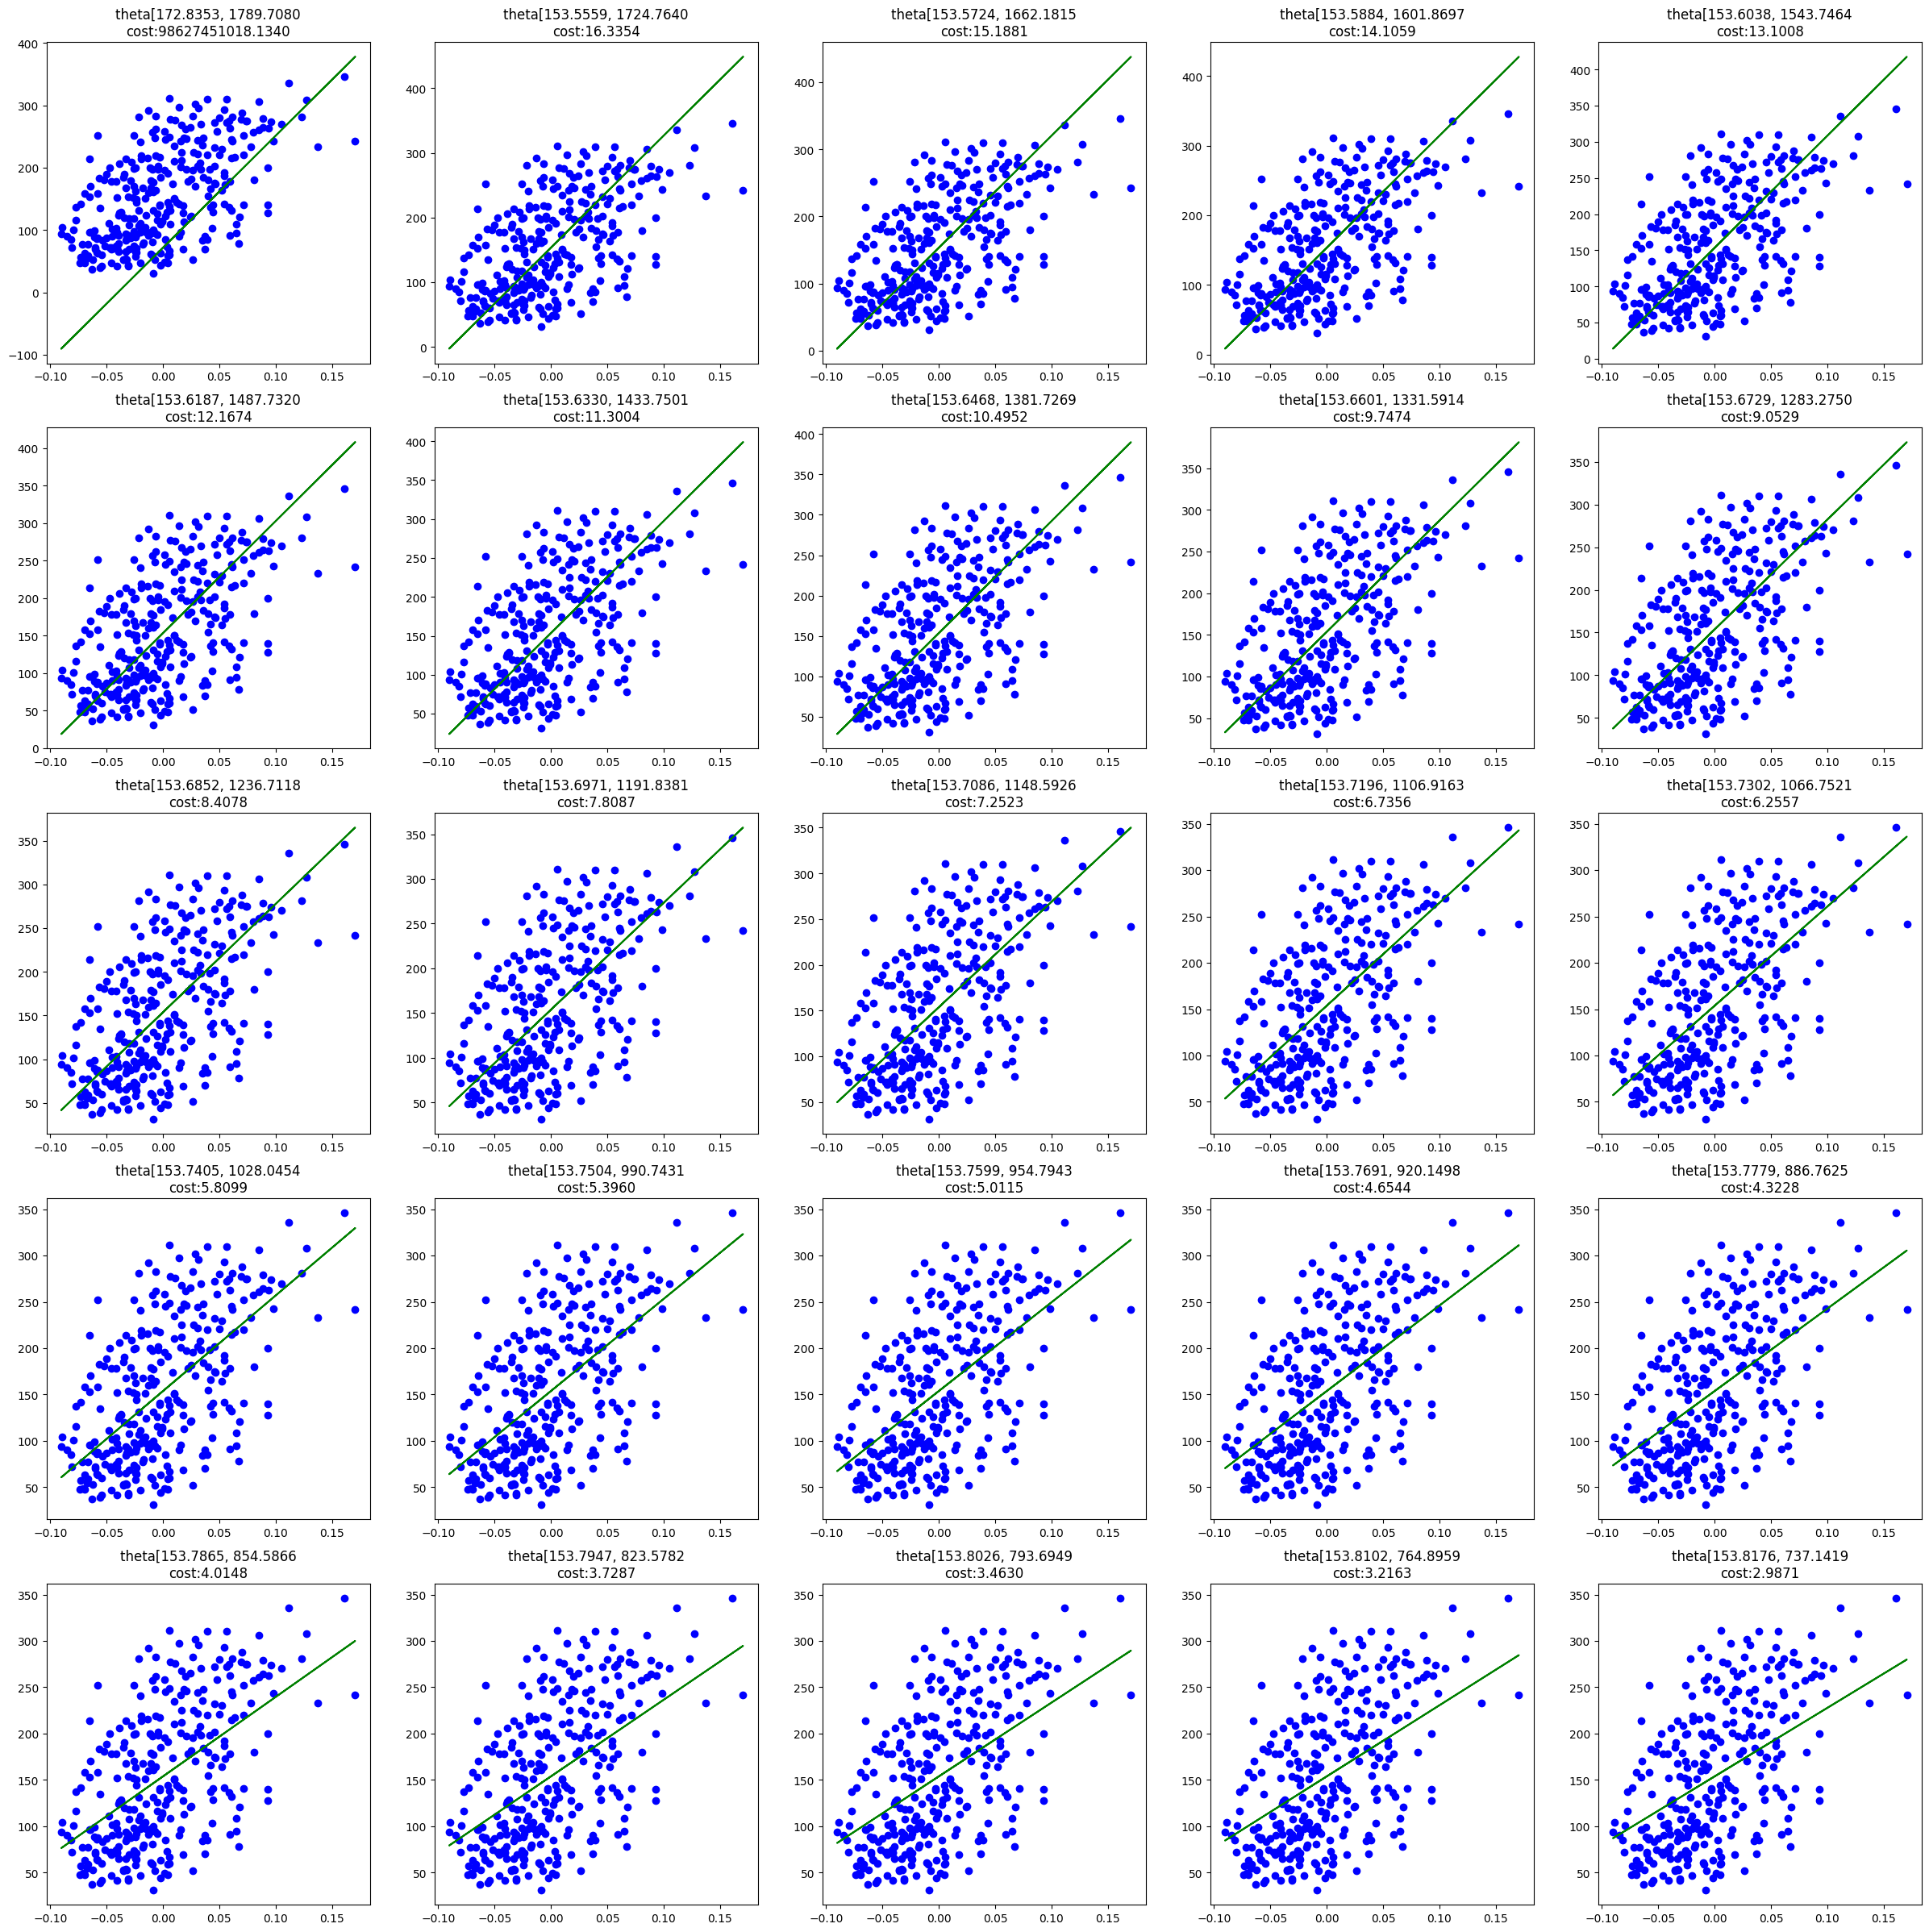

In [17]:
# Define the figure
plt.figure(figsize=(30,30))

# Define iterations
iterations = 325

# Define subplot increment
sub_plt_inc = iterations / 25

# Create 25 plots
for i in range(iterations):
  pred = univariate_linear_regression(theta, train_X)
  cost = compute_cost(pred, train_Y)
  theta = gd(theta, train_X, train_Y, pred, lr)

  if(i % sub_plt_inc == 0):
    k = i / sub_plt_inc
    plt.subplot(5,5, int(k) + 1)  # Convert k to an integer
    plt.scatter(train_X, train_Y, color='b')
    plt.plot(train_X, pred, 'g')

    s = 'theta[%.4f, %.4f' % (theta[0], theta[1])
    c = 'cost:%.4f' % cost
    plt.title(s+'\n'+c)

# Show the plots
plt.show()


Optimize the training against the dev set <br>

Text(0.5, 1.0, 'theta[153.8241, 712.4175\ncost:2134773.4986')

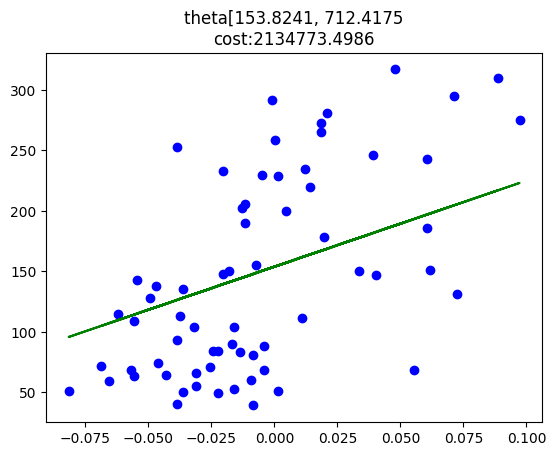

In [18]:
pred = univariate_linear_regression(theta, dev_X)
cost = compute_cost(pred, dev_Y)
plt.scatter(dev_X, dev_Y, color='b')
plt.plot(dev_X, pred, 'g')
s = 'theta[%.4f, %.4f' % (theta[0], theta[1])
c = 'cost:%.4f' % cost
plt.title(s+'\n'+c)

<br>Validate final model against the test set, including additional metrics to ensure we are not losing correlation to match the data perfectly.

R2: 0.36144283932679266, Explained Variance: 0.371314964749096


Text(0.5, 1.0, 'theta[153.8241, 712.4175\ncost:8144221.8118')

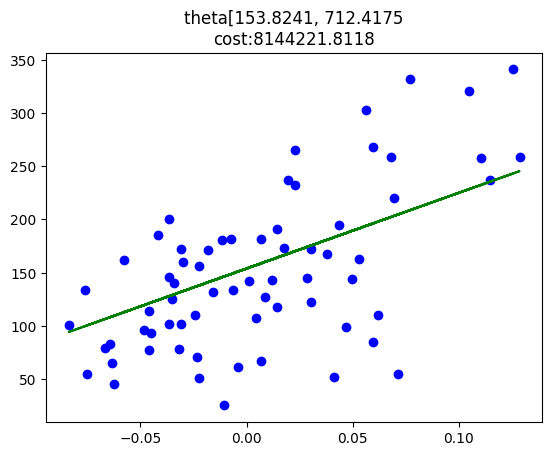

In [19]:
from sklearn.metrics import r2_score, explained_variance_score

pred = univariate_linear_regression(theta, test_X)
cost = compute_cost(pred, test_Y)
r2 = r2_score(test_Y, pred)
var = explained_variance_score(test_Y, pred)
print("R2: %s, Explained Variance: %s"%(r2, var))
plt.scatter(test_X, test_Y, color='b')
plt.plot(test_X, pred, 'g')
s = 'theta[%.4f, %.4f' % (theta[0], theta[1])
c = 'cost:%.4f' % cost
plt.title(s+'\n'+c)